## Count terms appearing in tweets

This notebook produces the graph with frequency counts of Dutch tweets related to the COVID-19 crisis. It relies on the texts of the tweets in the directory data/text and will count all the tweets in that directory. The notebook should be run every month after the tweets in the directory have been updated. Tweet counts are cached but generating the counts for one month will still take more than seven hours.

In [1]:
import gzip
import json
import os
import pandas as pd
import re
from IPython.display import clear_output

DATADIR = "../data/text/"
CSVDIR = "csv/"

In [2]:
TEXT = "text"
FULLTEXT = "full_text"
EXTENDEDTWEET = "extended_tweet"
RETWEETEDSTATUS = "retweeted_status"

def getTweetText(jsonData):
    text = ""
    if TEXT in jsonData: 
        text = jsonData[TEXT]
    if EXTENDEDTWEET in jsonData and \
       FULLTEXT in jsonData[EXTENDEDTWEET]:
        text = jsonData[EXTENDEDTWEET][FULLTEXT]
    if RETWEETEDSTATUS in jsonData and \
       EXTENDEDTWEET in jsonData[RETWEETEDSTATUS] and \
       FULLTEXT in jsonData[RETWEETEDSTATUS][EXTENDEDTWEET]:
        text = jsonData[RETWEETEDSTATUS][EXTENDEDTWEET][FULLTEXT]
    return(text)

In [3]:
from datetime import datetime, timedelta

DATEFORMAT = "%a %b %d %H:%M:%S %z %Y"
SUMMERTIMEDATE = datetime.strptime("Sun Mar 29 02:00:00 +0000 2020",DATEFORMAT)
WINTERTIMEDATE = datetime.strptime("Sun Oct 25 03:00:00 +0000 2020",DATEFORMAT)

def getTweetDate(jsonData):
    dateString = jsonData["created_at"]
    dateData = datetime.strptime(dateString,DATEFORMAT)+timedelta(hours=1)
    if dateData >= SUMMERTIMEDATE:
        if dateData >= WINTERTIMEDATE: sys.exit("cannot happen")
        dateData += timedelta(hours=1)
    return(int(dateData.strftime("%Y%m%d")))

In [4]:
CSVSUFFIX = ".csv"
DUTCH = "nl"
IDSTR = "id_str"
TOPIC = "topic"
DISTANCE = "distance"
LOCKDOWN = "lockdown"
VACCIN = "vaccin"
TEST = "test"
IK = "ik"
HAPPY = "happy"
LONELY = "lonely"
SWEAR = "swear"
PANDEMIC = "pandemic"
BASEQUERY = "corona|covid"
TOPICQUERY = "corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol"
PANDEMICQUERY = "|".join([TOPICQUERY, r'virus|besmet|ziekenhui|\bic\b|intensive.care|^zorg|vaccin|[^ad]arts|uitbraak|uitbrak|pandemie|ggd|'+
                                      r'mondkapje|quarantaine|\bwho\b|avondklok|variant|verple|sympto|e.golf|mutant|^omt$|umc|hcq|'+
                                      r'hydroxychloroquine|virolo|zkh|oversterfte|patiënt|patient|intensivist|🦠|ivermectin'])
DISTANCEQUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
LOCKDOWNQUERY = "lock.down|lockdown"
VACCINQUERY = "vaccin|ingeënt|ingeent|inent|prik|spuit|bijwerking|-->|💉|pfizer|moderna|astrazeneca|astra|zeneca|novavax|biontech"
TESTQUERY = r'\btest|getest|sneltest|pcr'
IKQUERY = r'\b(ik|mij|mijn|me|mn|m\'n|zelf|mezelf|mijzelf|i)\b'
HAPPYQUERY = r'\b(geluk|gelukkig|gelukkige|blij|happy)\b'
LONELYQUERY = r'eenza|alleen.*voel|voel.*alleen|lonely|loneli'
SWEARQUERY = (r'shit|fuck|klote|kanker|kut|lul|dom|reet|gvd|strot|waanzin|nep|rotzooi|idio|schaamtelo|fake|strot|'+
              r'zeik|stom|onbeschoft|oprot|bekrompen|ongelo|bah|kwalijk|onbekwa|achterlijk|jat|schand|triest|puinho|'+
              r'immore|kleptocratie|nepotism|absurd|misselijkma|\bbek\b|\brot\b|\bkk\b')

def saveCounts(counts, topic):
    pd.DataFrame.from_dict(counts, orient="index").to_csv(CSVDIR+topic+CSVSUFFIX, header=False)

def readCounts(topic):
    countsDf = pd.read_csv(CSVDIR+topic+CSVSUFFIX, header=None, index_col=0)
    return(countsDf.to_dict()[1])

def combineDicts(a,b):
    return(dict(list(a.items())+list(b.items())))

def search(query,countsIn):
    countsOut = {}
    countsInKeys = [ str(x) for x in countsIn ]
    seen = {}
    fileNames = sorted(os.listdir(DATADIR))
    for inFileName in fileNames:
        date = inFileName[0:8]
        if re.search(r"2*z",inFileName) and not date in countsInKeys:
            inFile = gzip.open(DATADIR+inFileName,mode="rt")
            for line in inFile:
                jsonData = json.loads(line)
                tweetText = getTweetText(jsonData)
                tweetDate = getTweetDate(jsonData)
                tweetLang = jsonData["lang"]
                if tweetLang == DUTCH and re.search(query,tweetText,flags=re.IGNORECASE):
                    if tweetDate in countsOut: countsOut[tweetDate] += 1
                    else: countsOut[tweetDate] = 1
            inFile.close()
            if not date in seen:
                print(date)
                seen[date] = True
    countsOut = combineDicts(countsIn,countsOut)
    countsOut = {k:v for k, v in sorted(countsOut.items(), key=lambda item: item[0])}
    return(countsOut)

def searchText(query,countsIn):
    countsOut = {}
    queryIn = query
    countsInKeys = [ str(x) for x in countsIn ]
    query2 = ""
    if query == TOPIC: query = TOPICQUERY
    elif query == DISTANCE: query = DISTANCEQUERY
    elif query == LOCKDOWN: query = LOCKDOWNQUERY
    elif query == VACCIN: query = VACCINQUERY
    elif query == TEST: query = TESTQUERY
    elif query == IK: query = IKQUERY
    elif query == HAPPY: 
        query = HAPPYQUERY
        query2 = IKQUERY
    elif query == LONELY: 
        query = LONELYQUERY
        query2 = IKQUERY
    elif query == SWEAR: query = SWEARQUERY
    elif query == PANDEMIC:
        query = "|".join([PANDEMICQUERY, TESTQUERY, VACCINQUERY, LOCKDOWNQUERY, DISTANCEQUERY])
    fileNames = sorted(os.listdir(DATADIR))
    selectedFileNames = [fileName for fileName in fileNames if fileName > "2020" ]
    for inFileName in selectedFileNames:
        date = inFileName[0:8]
        if re.search(r"2*z",inFileName) and not date in countsInKeys and inFileName > "20200201":
            if not date in countsOut: 
                countsOut[date] = 0
                print(date,query)
            df = pd.read_csv(DATADIR+inFileName,index_col=IDSTR)
            if query2 == "":
                countsOut[date] += len(df[df[TEXT].str.contains(query, flags=re.IGNORECASE)])
            else:
                countsOut[date] += len(df[df[TEXT].str.contains(query, flags=re.IGNORECASE) & 
                                          df[TEXT].str.contains(query2, flags=re.IGNORECASE)])
        countsSave = combineDicts(countsIn, countsOut)
        countsSave = {str(k):v for k, v in sorted(countsSave.items(), key=lambda item: str(item[0]))}
        saveCounts(countsSave, queryIn)
    return(countsSave)

def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

In [5]:
def count_tweets_per_month(file_pattern):
    month_data = {}
    fileNames = sorted(os.listdir(DATADIR))
    for file_name in fileNames:
        if re.search(file_pattern, file_name):
            squeal(file_name)
            month = file_name[:6]
            if not month in month_data:
                month_data[month] = { "counts":0, "hours":0, "dates":{} }  
            df = pd.read_csv(DATADIR+file_name, compression="gzip", engine="python")
            month_data[month]["counts"] += len(df)
            month_data[month]["hours"] += 1
            date = file_name[:8]
            month_data[month]["dates"][date] = True
    for month in month_data:
        if re.search("10$",month): 
            month_data[month]["hours"] += 1
        if re.search("03$",month): 
            month_data[month]["hours"] += -1
    return({m:[month_data[m]["counts"], 
               int(month_data[m]["counts"]/len(month_data[m]["dates"])), 
               int(month_data[m]["counts"]/month_data[m]["hours"])] for m in month_data})

count_tweets_per_month("202105")

20210531-23.out.gz


{'202105': [20731153, 668746, 27864]}

In [6]:
sum([15418685, 14851678, 21180942, 18715900, 18044679, 20807966,
     19154442, 20314042, 20340753, 21987100, 19393478, 20249944])

230459609

In [7]:
month_count_january_2020 = 15418685
month_counts = [           14851678, 21180942, 18715900, 18044679, 20807966,
                 19154442, 20314042, 20340753, 21987100, 19393478, 20249944,
                 23965828, 21076791, 25084625, 21383400, 20731153]

sum(month_counts)

327282721

In [8]:
IDSDIR = "../data/ids/"

def make_id_str_files():
    fileNames = sorted(os.listdir(DATADIR))
    for file_name in fileNames:
        out_file_name = re.sub("out", "txt", file_name)
        if re.search("^202", file_name) and not os.path.exists(IDSDIR+out_file_name):
            squeal(file_name)
            pd.read_csv(DATADIR+file_name, compression="gzip", 
                        engine="python")[IDSTR].to_csv(IDSDIR+out_file_name, compression="gzip", header=None, index=False)
            
make_id_str_files()

In [9]:
avondklok = readCounts("avondklok")
corona = readCounts("corona")
covid = readCounts("covid")
distance = readCounts(DISTANCE)
ik = readCounts(IK)
happy = readCounts(HAPPY)
lockdown = readCounts(LOCKDOWN)
lonely = readCounts(LONELY)
mondkapje = readCounts("mondkapje")
rivm = readCounts("rivm")
swear = readCounts(SWEAR)
test = readCounts(TEST)
topic = readCounts(TOPIC)
vaccin = readCounts(VACCIN)
pandemic = readCounts(PANDEMIC)
baseQuery = readCounts(BASEQUERY)

In [10]:
def deleteLastElement(myDict):
    if myDict: del(myDict[list(myDict.keys())[-1]])

def processData(dataContainer,queryName):
    dataContainer = searchText(queryName,dataContainer)
    saveCounts(dataContainer,queryName)
    return(dataContainer)

if True:
    baseQuery = processData(baseQuery, BASEQUERY)
    pandemic = processData(pandemic, PANDEMIC)
    avondklok = processData(avondklok, "avondklok")
    corona = processData(corona,"corona")
    covid = processData(covid,"covid")
    distance = processData(distance,DISTANCE)
    happy = processData(happy, HAPPY)
    ik = processData(ik, IK)
    lockdown = processData(lockdown,LOCKDOWN)
    lonely = processData(lonely, LONELY)
    mondkapje = processData(mondkapje,"mondkapje")
    rivm = processData(rivm,"rivm")
    swear = processData(swear, SWEAR)
    test = processData(test, TEST)
    topic = processData(topic,TOPIC)
    vaccin = processData(vaccin, VACCIN)

20210501 corona|covid
20210502 corona|covid
20210503 corona|covid
20210504 corona|covid
20210505 corona|covid
20210506 corona|covid
20210507 corona|covid
20210508 corona|covid
20210509 corona|covid
20210510 corona|covid
20210511 corona|covid
20210512 corona|covid
20210513 corona|covid
20210514 corona|covid
20210515 corona|covid
20210516 corona|covid
20210517 corona|covid
20210518 corona|covid
20210519 corona|covid
20210520 corona|covid
20210521 corona|covid
20210522 corona|covid
20210523 corona|covid
20210524 corona|covid
20210525 corona|covid
20210526 corona|covid
20210527 corona|covid
20210528 corona|covid
20210529 corona|covid
20210530 corona|covid
20210531 corona|covid
20210501 corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol|virus|besmet|ziekenhui|\bic\b|intensive.care|^zorg|vaccin|[^ad]arts|uitbraak|uitbrak|pandemie|ggd|mondkapje|quarantaine|\bwho\b|avondklok|variant|verple|sympto|e.golf|mutant|^omt$|umc|hcq|hydroxychloroquine|virolo|zkh|oversterfte|patiënt|

/home/erikt/anaconda3/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


20210502 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210503 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210504 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210505 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210506 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210507 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210508 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210509 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210510 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210511 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210512 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210513 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210514 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210515 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210516 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210517 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210518 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210519 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210520 \b(geluk|gelukkig|gelukkige|blij|happy)\b
20210521 \b(geluk|gelukkig|gelu

In [11]:
data = pandemic
monthCounts = {}
for date in data:
    month = str(date)[0:6]
    if not month in monthCounts: monthCounts[month] = 0
    monthCounts[month] += data[date]
monthCounts["total"] = sum(monthCounts.values())
sum([monthCounts[month] for month in monthCounts if re.search("^202[10]", month)])

39081187

In [12]:
monthCounts

{'202002': 565744,
 '202003': 4538528,
 '202004': 3208165,
 '202005': 2100201,
 '202006': 1727603,
 '202007': 1642182,
 '202008': 1918835,
 '202009': 1965168,
 '202010': 2788461,
 '202011': 1600734,
 '202012': 2538857,
 '202101': 3302560,
 '202102': 2836393,
 '202103': 3070363,
 '202104': 2820203,
 '202105': 2457190,
 'total': 39081187}

In [13]:
month_counts = [           565744, 4538528, 3208165, 2100201, 1727603,
                 1642182, 1918835, 1965168, 2788461, 1600734, 2538857,
                 3302560, 2836393, 3070363, 2820203 ]
sum(month_counts)

36623997

In [14]:
import math
from warnings import warn

WEEKLENGTH = 7

def summarize(myDict,index,count):
    counter = 0
    mySum = 0
    myKeys = list(myDict.keys())
    for i in range(0,count):
        if index-i >= 0 and not math.isnan(myDict[myKeys[index-i]]):
            counter += 1
            mySum += myDict[myKeys[index-i]]
            if myKeys[index-i] > myKeys[index]:
                warn("keys are not sorted!")
    if counter == 0: return(math.nan)
    else: return(mySum/counter)

rivm7 = {list(rivm.keys())[i]:summarize(rivm,i,WEEKLENGTH) for i in range(0,len(rivm))}
corona7 = {list(corona.keys())[i]:summarize(corona,i,WEEKLENGTH) for i in range(0,len(corona))}
covid7 = {list(covid.keys())[i]:summarize(covid,i,WEEKLENGTH) for i in range(0,len(covid))}
mondkapje7 = {list(mondkapje.keys())[i]:summarize(mondkapje,i,WEEKLENGTH) for i in range(0,len(mondkapje))}
topic7 = {list(topic.keys())[i]:summarize(topic,i,WEEKLENGTH) for i in range(0,len(topic))}
distance7 = {list(distance.keys())[i]:summarize(distance,i,WEEKLENGTH) for i in range(0,len(distance))}
lockdown7 = {list(lockdown.keys())[i]:summarize(lockdown,i,WEEKLENGTH) for i in range(0,len(lockdown))}
vaccin7 = {list(vaccin.keys())[i]:summarize(vaccin,i,WEEKLENGTH) for i in range(0,len(vaccin))}
test7 = {list(test.keys())[i]:summarize(test,i,WEEKLENGTH) for i in range(0,len(test))}
ik7 = {list(ik.keys())[i]:summarize(ik,i,WEEKLENGTH) for i in range(0,len(ik))}
avondklok7 = {list(avondklok.keys())[i]:summarize(avondklok,i,WEEKLENGTH) for i in range(0,len(avondklok))}
happy7 = {list(happy.keys())[i]:summarize(happy,i,WEEKLENGTH) for i in range(0,len(happy))}
lonely7 = {list(lonely.keys())[i]:summarize(lonely,i,WEEKLENGTH) for i in range(0,len(lonely))}
swear7 = {list(swear.keys())[i]:summarize(swear,i,WEEKLENGTH) for i in range(0,len(swear))}
pandmic7 = {list(pandemic.keys())[i]:summarize(pandemic,i,WEEKLENGTH) for i in range(0,len(pandemic))}

### Plot absolute values

In [15]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [24]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
#%matplotlib inline

DATEFORMATPLOT = "%Y%m%d"
PLOTFILEOUT = "tweet-frequencies.png"
LAST_PLOT_DATE = "20210610"

def getWeekendDates(dateStrings):
    weekendDates = []
    for ds in dateStrings:
        d = datetime.strptime(str(ds),DATEFORMATPLOT)
        if d == 0 or d == 6: weekendDates.append(d)
            
def stringArrayToDates(stringList,dateFormat=DATEFORMATPLOT):
    return([datetime.strptime(str(date),dateFormat) for date in stringList])

def prettyPrintNumber(number):
    digits = str(number)
    prettyNumber = ""
    for i in range(-1,-len(digits)-1,-1):
        prettyNumber = digits[i]+prettyNumber
        if i % 3 == 0 and i > -len(digits): prettyNumber = ","+prettyNumber
    return(prettyNumber)

def makeLabel(name,myDict):
    if name == TOPIC: label = "topic"
    elif name == DISTANCE: label = "social distancing"
    elif name == "rivm": label = "RIVM"
    elif name == "mondkapje": label = "face masks"
    else: label = name
    return(label+" ("+prettyPrintNumber(sum(myDict.values()))+" tweets)")

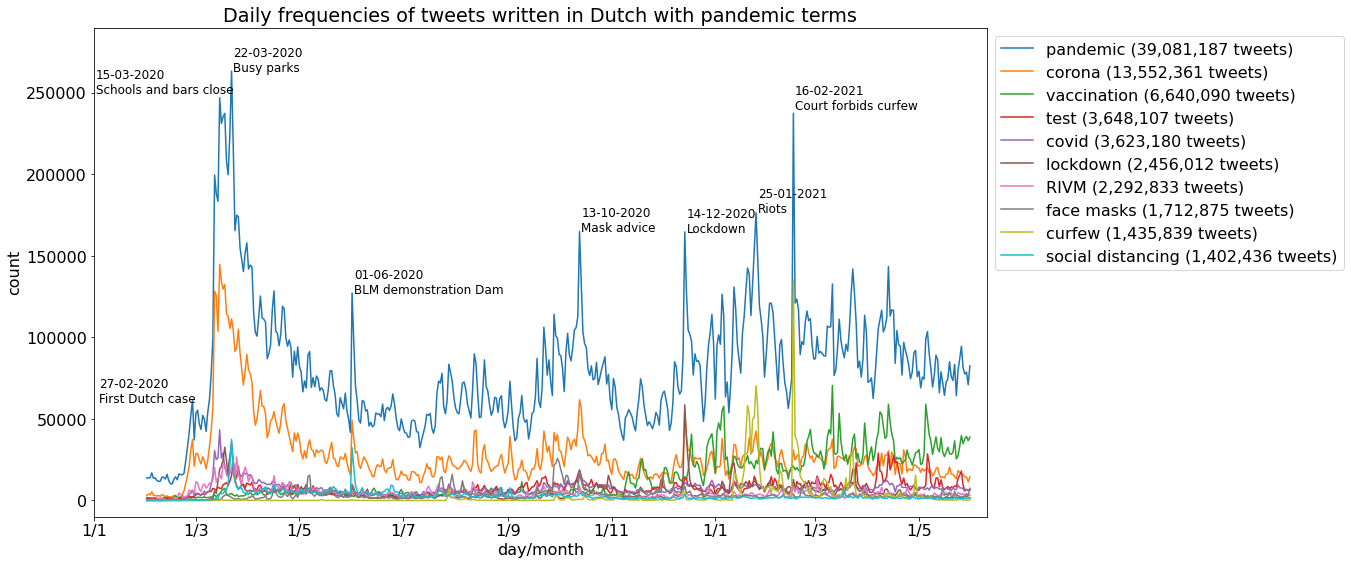

In [25]:
weekendDates = getWeekendDates(rivm.keys())
font = {"size":16}
matplotlib.rc("font",**font)
plt.figure(figsize=(16,9))
ax1 = plt.subplot(111)
#ax1.plot_date(stringArrayToDates(ik.keys()),list(ik.values()),xdate=True,fmt="-",label=makeLabel("ik",ik))
ax1.plot_date(stringArrayToDates(pandemic.keys()),list(pandemic.values()),xdate=True,fmt="-",label=makeLabel("pandemic",pandemic))
#ax1.plot_date(stringArrayToDates(topic.keys()),list(topic.values()),xdate=True,fmt="-",label=makeLabel(TOPIC,topic))
#ax1.plot_date(stringArrayToDates(swear.keys()),list(swear.values()),xdate=True,fmt="-",label=makeLabel("swear",swear))
#ax1.plot_date(stringArrayToDates(baseQuery.keys()),list(baseQuery.values()),xdate=True,fmt="-",label=makeLabel("basic query",baseQuery))
ax1.plot_date(stringArrayToDates(corona.keys()),list(corona.values()),xdate=True,fmt="-",label=makeLabel("corona",corona))
ax1.plot_date(stringArrayToDates(vaccin.keys()),list(vaccin.values()),xdate=True,fmt="-",label=makeLabel("vaccination",vaccin))
ax1.plot_date(stringArrayToDates(test.keys()),list(test.values()),xdate=True,fmt="-",label=makeLabel("test",test))
ax1.plot_date(stringArrayToDates(covid.keys()),list(covid.values()),xdate=True,fmt="-",label=makeLabel("covid",covid))
ax1.plot_date(stringArrayToDates(lockdown.keys()),list(lockdown.values()),xdate=True,fmt="-",label=makeLabel(LOCKDOWN,lockdown))
ax1.plot_date(stringArrayToDates(rivm.keys()),list(rivm.values()),xdate=True,fmt="-",label=makeLabel("rivm",rivm))
ax1.plot_date(stringArrayToDates(mondkapje.keys()),list(mondkapje.values()),xdate=True,fmt="-",label=makeLabel("mondkapje",mondkapje))
#ax1.plot_date(stringArrayToDates(happy.keys()),list(happy.values()),xdate=True,fmt="-",label=makeLabel("happy",happy))
ax1.plot_date(stringArrayToDates(avondklok.keys()),list(avondklok.values()),xdate=True,fmt="-",label=makeLabel("curfew",avondklok))
ax1.plot_date(stringArrayToDates(distance.keys()),list(distance.values()),xdate=True,fmt="-",label=makeLabel(DISTANCE,distance))
#ax1.plot_date(stringArrayToDates(lonely.keys()),list(lonely.values()),xdate=True,fmt="-",label=makeLabel("lonely",lonely))

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
#dummy = ax1.legend(bbox_to_anchor=(0.68,1), loc="upper right")
plt.title("Daily frequencies of tweets written in Dutch with pandemic terms")
plt.xlabel("day/month")
plt.ylabel("count")
#plt.yscale("log")
plt.ylim((-10000,290000))
plt.xlim((datetime.strptime("20200101", DATEFORMATPLOT), datetime.strptime(LAST_PLOT_DATE, DATEFORMATPLOT)))
for tuple_data in [["20200104",  59999, "27-02-2020\nFirst Dutch case"],
                   ["20200102", 249500, "15-03-2020\nSchools and bars close"],
                   ["20200323", 263330, "22-03-2020\nBusy parks"],
                   ["20200602", 127236, "01-06-2020\nBLM demonstration Dam"],
                   ["20201014", 164966, "13-10-2020\nMask advice"],
                   ["20201215", 164705, "14-12-2020\nLockdown"],
                   ["20210126", 176460, "25-01-2021\nRiots"],
                   ["20210217", 240000, "16-02-2021\nCourt forbids curfew"],
                  ]:
    plt.text(datetime.strptime(tuple_data[0], DATEFORMATPLOT), tuple_data[1], tuple_data[2], fontsize=12)
ax1.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig(PLOTFILEOUT, bbox_inches='tight')
plt.show()

## DHBenelux 2021 plot

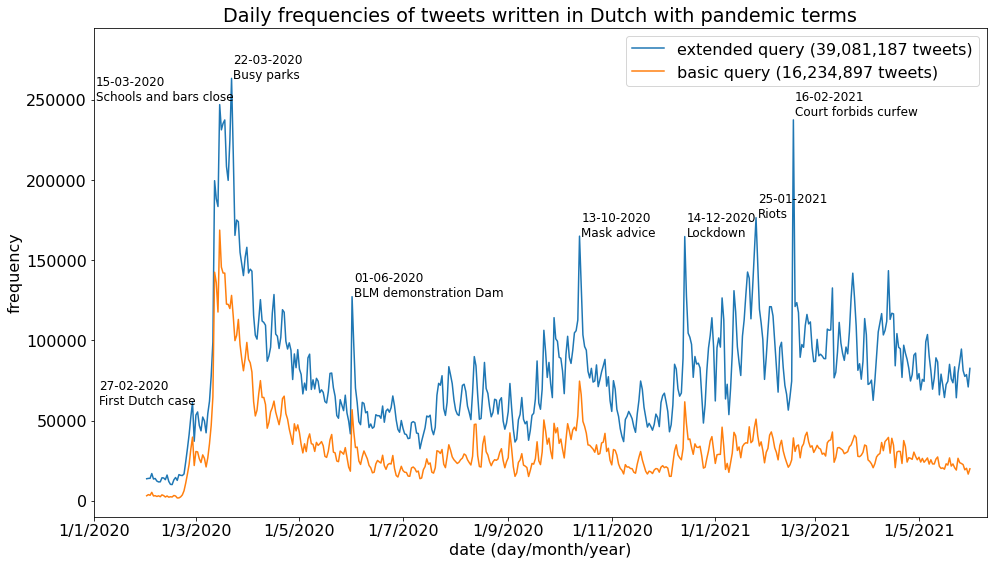

In [27]:
weekendDates = getWeekendDates(rivm.keys())
font = {"size":16}
matplotlib.rc("font",**font)
plt.figure(figsize=(16,9))
ax1 = plt.subplot(111)
ax1.plot_date(stringArrayToDates(pandemic.keys()),list(pandemic.values()),xdate=True,fmt="-",label=makeLabel("extended query",pandemic))
ax1.plot_date(stringArrayToDates(baseQuery.keys()),list(baseQuery.values()),xdate=True,fmt="-",label=makeLabel("basic query",baseQuery))

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m/%-Y"))
#dummy = ax1.legend(bbox_to_anchor=(0.68,1), loc="upper right")
plt.title("Daily frequencies of tweets written in Dutch with pandemic terms")
plt.xlabel("date (day/month/year)")
plt.ylabel("frequency")
#plt.yscale("log")
plt.ylim((-10000,295000))
plt.xlim((datetime.strptime("20200101", DATEFORMATPLOT), datetime.strptime(LAST_PLOT_DATE, DATEFORMATPLOT)))
for tuple_data in [["20200104",  59999, "27-02-2020\nFirst Dutch case"],
                   ["20200102", 249500, "15-03-2020\nSchools and bars close"],
                   ["20200323", 263330, "22-03-2020\nBusy parks"],
                   ["20200602", 127236, "01-06-2020\nBLM demonstration Dam"],
                   ["20201014", 164966, "13-10-2020\nMask advice"],
                   ["20201215", 164705, "14-12-2020\nLockdown"],
                   ["20210126", 176460, "25-01-2021\nRiots"],
                   ["20210217", 240000, "16-02-2021\nCourt forbids curfew"],
                  ]:
    plt.text(datetime.strptime(tuple_data[0], DATEFORMATPLOT), tuple_data[1], tuple_data[2], fontsize=12)
ax1.legend()
plt.savefig("tweet-frequencies-dhbenelux-final.png", bbox_inches='tight')
plt.show()

In [28]:
{date:pandemic[date] for date in sorted(pandemic.keys(), key=lambda date:pandemic[date], reverse=True) if re.search("^202103", str(date))}

{'20210323': 141886,
 '20210311': 132672,
 '20210324': 126848,
 '20210322': 126115,
 '20210330': 113580,
 '20210315': 111195,
 '20210325': 108849,
 '20210308': 107037,
 '20210310': 106508,
 '20210309': 106292,
 '20210321': 105277,
 '20210331': 103439,
 '20210302': 100617,
 '20210316': 98323,
 '20210319': 95818,
 '20210314': 92806,
 '20210317': 91873,
 '20210320': 91595,
 '20210304': 91333,
 '20210303': 90361,
 '20210305': 90228,
 '20210306': 88619,
 '20210307': 88562,
 '20210318': 87531,
 '20210301': 86991,
 '20210329': 86820,
 '20210327': 85430,
 '20210326': 81322,
 '20210313': 80039,
 '20210312': 76635,
 '20210328': 75762}

### Plot normalized values

This code needs the contents of the file date-counts.csv to be up-to-date. The data for the file can be computed with shell code executed in a terminal in the directory data/text (adjust month in command):
```for FILE in 202101??-00*; do DATE=`echo $FILE|cut -c1-8`; COUNT=`gunzip -c ${DATE}*|grep -v '^[^0-9]'|wc -l`; echo $DATE,$COUNT; done >> ../date-counts.csv```

In [29]:
import pandas as pd

def normalize(dateCounts,countsIn):
    countsOut = {}
    for key in countsIn:
        if int(key) in dateCounts.index: 
            countsOut[key] = countsIn[key]/dateCounts.loc[int(key)]["count"]
    return(countsOut)

dateCounts = pd.read_csv(DATADIR+"../date-counts.csv",index_col=["date"])

In [30]:
rivmNorm = normalize(dateCounts,rivm)
coronaNorm = normalize(dateCounts,corona)
covidNorm = normalize(dateCounts,covid)
mondkapjeNorm = normalize(dateCounts,mondkapje)
topicNorm = normalize(dateCounts,topic)
distanceNorm = normalize(dateCounts,distance)
lockdownNorm = normalize(dateCounts,lockdown)
vaccinNorm = normalize(dateCounts,vaccin)
testNorm = normalize(dateCounts,test)
ikNorm = normalize(dateCounts,ik)
avondklokNorm = normalize(dateCounts,avondklok)
happyNorm = normalize(dateCounts,happy)
lonelyNorm = normalize(dateCounts,lonely)
swearNorm = normalize(dateCounts,swear)
pandemicNorm = normalize(dateCounts,pandemic)

rivmNorm7 = {list(rivmNorm.keys())[i]:summarize(rivmNorm,i,WEEKLENGTH) for i in range(0,len(rivmNorm))}
coronaNorm7 = {list(coronaNorm.keys())[i]:summarize(coronaNorm,i,WEEKLENGTH) for i in range(0,len(coronaNorm))}
covidNorm7 = {list(covidNorm.keys())[i]:summarize(covidNorm,i,WEEKLENGTH) for i in range(0,len(covidNorm))}
mondkapjeNorm7 = {list(mondkapjeNorm.keys())[i]:summarize(mondkapjeNorm,i,WEEKLENGTH) for i in range(0,len(mondkapjeNorm))}
topicNorm7 = {list(topicNorm.keys())[i]:summarize(topicNorm,i,WEEKLENGTH) for i in range(0,len(topicNorm))}
distanceNorm7 = {list(distanceNorm.keys())[i]:summarize(distanceNorm,i,WEEKLENGTH) for i in range(0,len(distanceNorm))}
lockdownNorm7 = {list(lockdownNorm.keys())[i]:summarize(lockdownNorm,i,WEEKLENGTH) for i in range(0,len(lockdownNorm))}
vaccinNorm7 = {list(vaccinNorm.keys())[i]:summarize(vaccinNorm,i,WEEKLENGTH) for i in range(0,len(vaccinNorm))}
testNorm7 = {list(testNorm.keys())[i]:summarize(testNorm,i,WEEKLENGTH) for i in range(0,len(testNorm))}
ikNorm7 = {list(ikNorm.keys())[i]:summarize(ikNorm,i,WEEKLENGTH) for i in range(0,len(ikNorm))}
avondklokNorm7 = {list(avondklokNorm.keys())[i]:summarize(avondklokNorm,i,WEEKLENGTH) for i in range(0,len(avondklokNorm))}
happyNorm7 = {list(happyNorm.keys())[i]:summarize(happyNorm,i,WEEKLENGTH) for i in range(0,len(happyNorm))}
lonelyNorm7 = {list(lonelyNorm.keys())[i]:summarize(lonelyNorm,i,WEEKLENGTH) for i in range(0,len(lonelyNorm))}
swearNorm7 = {list(swearNorm.keys())[i]:summarize(swearNorm,i,WEEKLENGTH) for i in range(0,len(swearNorm))}
pandemicNorm7 = {list(pandemicNorm.keys())[i]:summarize(pandemicNorm,i,WEEKLENGTH) for i in range(0,len(pandemicNorm))}

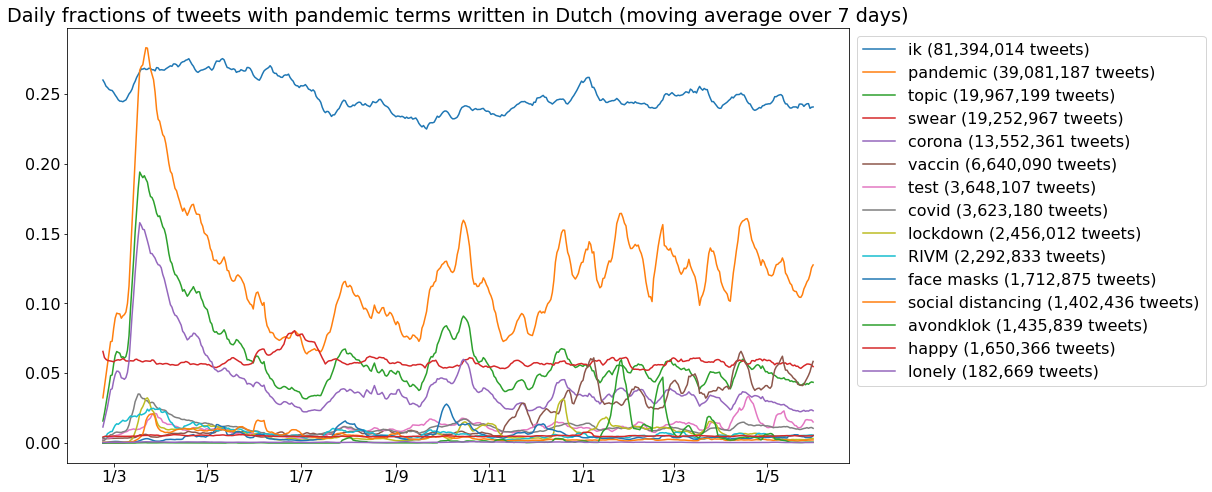

In [36]:
plt.figure(figsize=(14,8))
ax2 = plt.subplot(111)
ax2.plot_date(stringArrayToDates(ikNorm7.keys()),list(ikNorm7.values()),xdate=True,fmt="-",label=makeLabel(IK,ik))
ax2.plot_date(stringArrayToDates(pandemicNorm7.keys()),list(pandemicNorm7.values()),xdate=True,fmt="-",label=makeLabel("pandemic",pandemic))
ax2.plot_date(stringArrayToDates(topicNorm7.keys()),list(topicNorm7.values()),xdate=True,fmt="-",label=makeLabel("topic",topic))
ax2.plot_date(stringArrayToDates(swearNorm7.keys()),list(swearNorm7.values()),xdate=True,fmt="-",label=makeLabel("swear",swear))
ax2.plot_date(stringArrayToDates(coronaNorm7.keys()),list(coronaNorm7.values()),xdate=True,fmt="-",label=makeLabel("corona",corona))
ax2.plot_date(stringArrayToDates(vaccinNorm7.keys()),list(vaccinNorm7.values()),xdate=True,fmt="-",label=makeLabel(VACCIN,vaccin))
ax2.plot_date(stringArrayToDates(testNorm7.keys()),list(testNorm7.values()),xdate=True,fmt="-",label=makeLabel(TEST,test))
ax2.plot_date(stringArrayToDates(covidNorm7.keys()),list(covidNorm7.values()),xdate=True,fmt="-",label=makeLabel("covid",covid))
ax2.plot_date(stringArrayToDates(lockdownNorm7.keys()),list(lockdownNorm7.values()),xdate=True,fmt="-",label=makeLabel(LOCKDOWN,lockdown))
ax2.plot_date(stringArrayToDates(rivmNorm7.keys()),list(rivmNorm7.values()),xdate=True,fmt="-",label=makeLabel("rivm",rivm))
ax2.plot_date(stringArrayToDates(mondkapjeNorm7.keys()),list(mondkapjeNorm7.values()),xdate=True,fmt="-",label=makeLabel("mondkapje",mondkapje))
ax2.plot_date(stringArrayToDates(distanceNorm7.keys()),list(distanceNorm7.values()),xdate=True,fmt="-",label=makeLabel("distance",distance))
ax2.plot_date(stringArrayToDates(avondklokNorm7.keys()),list(avondklokNorm7.values()),xdate=True,fmt="-",label=makeLabel("avondklok",avondklok))
ax2.plot_date(stringArrayToDates(happyNorm7.keys()),list(happyNorm7.values()),xdate=True,fmt="-",label=makeLabel("happy",happy))
ax2.plot_date(stringArrayToDates(lonelyNorm7.keys()),list(lonelyNorm7.values()),xdate=True,fmt="-",label=makeLabel("lonely",lonely))

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.title("Daily fractions of tweets with pandemic terms written in Dutch (moving average over 7 days)")
#plt.xticks([datetime.strptime(d,DATEFORMATPLOT) for d in "20200301 20200401 20200501 20200601 20200701 20200801 20200901 20201001 20201101".split()])
dummy = ax2.legend(bbox_to_anchor=(1,1), loc="upper left")

## Content analysis

In [ ]:
import gzip
import json
import os
import numpy as np
import pandas as pd
import re

DATADIR = "../data/all/"
ID = "id_str"
LANG = "lang"
USER = "user"
SCREENNAME = "screen_name"
RIVM = "rivm"
DUTCH = "nl"
TARGETDATES = ["20200412","20200413","20200414","20200415","20200416","20200417","20200418"]
QUERY = "mondkapje"

def removeNewlines(text):
    return(re.sub(r"\n"," ",text))

fileNames = os.listdir(DATADIR)
texts = {}
dates = {}
for inFileName in fileNames:
    inFileDate = inFileName[0:8]
    if inFileDate in TARGETDATES:
        inFile = gzip.open(DATADIR+inFileName,mode="rt")
        for line in inFile:
            jsonData = json.loads(line)
            tweetText = removeNewlines(getTweetText(jsonData))
            tweetLang = jsonData[LANG]
            tweetId = jsonData[ID]
            tweetUser = jsonData[USER][SCREENNAME]
            if tweetLang == DUTCH and \
               re.search(QUERY,tweetText,flags=re.IGNORECASE) and \
               re.search(RIVM,tweetText,flags=re.IGNORECASE):
                texts[tweetId] = {"user":tweetUser,"text":tweetText}
                dates[tweetId] = int(inFileDate)
        inFile.close()
len(texts)

In [ ]:
pd.DataFrame.from_dict(texts,orient="index").to_csv("mondkapje-tweets.csv",header=False)

In [ ]:
ANNOTATIONFILE = DATADIR+"../"+"mondkapje-tweets.csv.human-labels.txt"

def readAnnotations(annotationFile):
    inFile = open(annotationFile,"r")
    annotations = {}
    minutes = {}
    for line in inFile:
        (userName,date,tweetId,nbr,label) = line.strip().split()
        if not userName in annotations: 
            annotations[userName] = {}
            minutes[userName] = {}
        annotations[userName][tweetId] = label
        minutes[userName][date[0:12]] = True
    inFile.close()
    for userName in annotations:
        print("annotation time of user {0}: {1:d} messages in {2:d} minutes ({3:0.1f} tweets per minute)".\
              format(userName,len(annotations[userName]),len(minutes[userName]),round(len(annotations[userName])/len(minutes[userName]),1)))
    return(annotations)

annotations = readAnnotations(ANNOTATIONFILE)

In [ ]:
for annotationFile in "202007-distance-twitter.csv.human-labels.txt 202007-distance-nunl.csv.human-labels.txt \
                       202007-distance-reddit.csv.human-labels.txt".split():
    dummy = readAnnotations("../data/"+annotationFile)

In [ ]:
dummy = readAnnotations("../data/"+"distance-tweets.csv.human-labels.txt")

In [ ]:
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
NEGATIVE = "NEGATIVE"
POSITIVE = "POSITIVE"

labelsPerDate = {}
totals = {}
for tweetId in dates:
    if tweetId in annotations and annotations[tweetId] != IRRELEVANT:
        date = int(dates[tweetId])
        label = annotations[tweetId]
        if not date in labelsPerDate: labelsPerDate[date] = {}
        labelsPerDate[date][label] = labelsPerDate[date][label]+1 if label in labelsPerDate[date] else 1
        totals[label] = totals[label]+1 if label in totals else 1
labelsPerDate

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

labels = {"NEGATIVE":"rejects","POSITIVE":"supports","NEUTRAL":"neutral"}
percentages = {key:round(100*totals[key]/sum(totals.values())) for key in totals}
font = {"size":16}
matplotlib.rc("font",**font)

for date in labelsPerDate:
    for label in [NEGATIVE,NEUTRAL,POSITIVE]:
        if not label in labelsPerDate[date]:
            labelsPerDate[date][label] = 0

negative = [labelsPerDate[date][NEGATIVE] for date in labelsPerDate.keys()]
neutral = [labelsPerDate[date][NEUTRAL] for date in labelsPerDate.keys()]
positive = [labelsPerDate[date][POSITIVE] for date in labelsPerDate.keys()]
negplusneu = [negative[i]+neutral[i] for i in range(0,len(neutral))]
plt.figure(figsize=(12,8))
plt.bar(list(labelsPerDate.keys()),positive,label=labels[POSITIVE]+" ("+str(percentages[POSITIVE])+"%)",bottom=negplusneu)
plt.bar(list(labelsPerDate.keys()),neutral,label=labels[NEUTRAL]+" ("+str(percentages[NEUTRAL])+"%)",bottom=negative)
plt.bar(list(labelsPerDate.keys()),negative,label=labels[NEGATIVE]+" ("+str(percentages[NEGATIVE])+"%)",color="r")
plt.title("Twitter stance on RIVM advising against facemask use by general public")
plt.xticks(list(labelsPerDate.keys()),["Fri 17/4","Wed 15/4","Sun 12/4","Thu 16/4","Mon 13/4","Tue 14/4"])
plt.legend()
plt.show()

## twiqs.nl tweets per month (alltime)

In [ ]:
from datetime import datetime
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
DATAFILE = "../data/months.txt"
DATEFORMAT = "%Y%m"

In [ ]:
df = pd.read_csv(DATAFILE,sep=" ",header=None,index_col=0)

In [ ]:
font = {"size":14}
matplotlib.rc("font",**font)
plt.figure(figsize=(12,8))
ax2 = plt.subplot(111)
ax2.set_ylim([0,90000000])
ax2.plot_date([datetime.strptime(str(month),DATEFORMAT) for month in df.index if month > 201100],\
               [df.loc[month][1] for month in df.index if month > 201100],fmt="-")
plt.title("number of Dutch tweets collected by twiqs.nl per month")
plt.show()